In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
#Set random seeds for reprodcutibility
torch.manual_seed(42)

In [4]:
#Check for GPU
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [27]:
df=pd.read_csv('/fmnist_small.csv')

In [28]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,0,0,0,0,0,0,0,0,1,147,114,108,110,108,74,55,113,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,246,...,238,215,255,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,74,145,6,0,0,27,137,76,69,12,0,0,0,0,0,0,0,0
5996,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5997,8,0,0,0,0,0,0,0,0,0,0,0,23,125,109,104,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,68,...,139,157,186,252,255,154,53,238,0,0,0,0,0,0,11,61,0,0,36,91,67,93,126,133,135,139,135,143,132,79,39,47,2,0,0,29,0,0,0,0
5998,4,0,0,0,0,0,0,0,0,0,1,0,0,140,109,118,151,58,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,240,243,227,70,0,235,189,188,64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,70,55,33,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


In [30]:
df.sample(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
3913,6,0,0,0,0,0,0,0,0,0,2,0,32,139,161,153,142,51,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,134,141,153,74,0,191,168,162,51,0,0,0,0,0,0,0,14,18,20,0,0,33,56,73,107,86,85,82,84,51,9,0,0,28,14,14,0,0,0,0
4065,2,0,0,0,0,1,0,0,0,0,103,210,197,146,135,151,149,186,194,81,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,19,130,200,212,193,...,251,222,217,255,66,66,254,231,91,0,0,0,0,0,0,6,133,152,0,12,109,104,114,116,116,116,112,103,96,84,68,64,0,0,178,151,4,0,0,0
5970,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4653,2,0,0,0,0,0,0,0,0,0,1,0,0,129,132,118,160,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,216,255,141,0,0,0,0,0,0,0,0,0,148,152,0,0,3,0,0,0,0,0,0,0,0,0,0,0,92,175,64,0,0,0,0
5353,1,0,0,0,0,0,0,0,0,90,235,198,204,205,204,203,203,205,203,236,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,254,224,...,192,194,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,106,98,100,0,0,57,89,87,3,0,0,0,0,0,0,0,0,0


In [31]:
df.isnull().sum()

,0
label,0
pixel1,0
pixel2,0
pixel3,0
pixel4,0
...,...
pixel780,0
pixel781,0
pixel782,0
pixel783,0


In [32]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.0,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000
mean,4.489667,0.0,0.003333,0.022833,0.095833,0.229667,0.380833,0.815000,2.040500,5.851500,14.575667,32.645833,45.334000,52.188000,50.954333,50.805833,54.524333,52.473333,40.571333,25.828667,10.930167,4.021500,2.085500,1.319000,0.876833,0.505000,0.224667,0.100000,0.031500,0.00100,0.017333,0.064667,0.303500,0.749667,1.977667,7.160167,17.772667,31.986333,51.563667,78.08050,...,93.840667,91.377500,80.467667,63.967833,46.608333,45.003500,49.173000,40.018500,22.472500,9.095667,3.702833,0.633833,0.029500,0.268500,1.086333,4.576000,13.541500,21.664833,21.630167,17.589333,22.676167,31.478167,41.920333,51.787000,53.129333,47.392333,43.291667,45.932667,50.463833,46.405333,34.411500,23.410833,16.781833,18.320167,23.820167,18.936833,9.157167,2.783833,0.903833,0.09300
std,2.840464,0.0,0.075210,0.457180,2.494464,4.855634,5.883755,8.964309,13.320114,24.088175,38.581162,58.430732,65.769669,68.776808,68.215488,67.911188,69.983508,68.608844,63.102802,51.503544,33.753580,19.978861,14.715897,11.664973,9.518776,7.259368,4.098210,3.250861,1.852047,0.03161,0.898239,2.963323,6.079848,9.413577,15.212607,28.975779,48.303011,66.002923,81.297935,94.53404,...,101.171364,100.017643,95.687864,89.567882,79.155205,77.821234,84.163228,75.800665,56.000833,37.691537,23.881700,8.194019,1.117514,5.333087,10.245944,21.750266,38.370488,49.932168,49.020950,42.682373,48.756064,55.592553,61.727639,67.919058,69.857669,67.766246,65.990179,66.825777,68.464501,65.366420,57.150747,48.769483,42.327168,44.743938,53.096607,46.870204,31.205610,17.486349,9.630180,2.54508
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 35.9 MB


In [34]:
df.shape

(6000, 785)

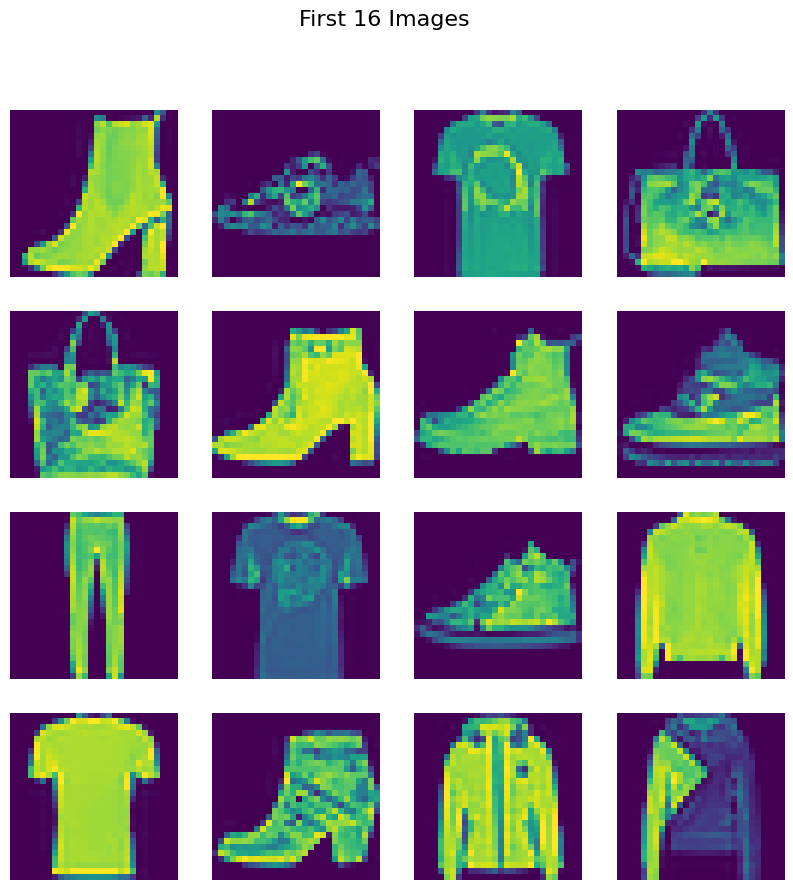

In [35]:
#Create a 4x4 grid of images
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize=16)

#Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')

In [36]:
#train test split
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
X_train=X_train/255.0
X_test=X_test/255.0

In [39]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):

    #Convert to PyTorch tensors
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [40]:
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)
#

In [41]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

In [42]:
len(train_loader)

75

In [43]:
class MyNN(nn.Module):
  def __init__(self,num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64,10)
    )

  def forward(self,x):
    return self.model(x)

In [44]:
learning_rate=0.1
epochs=100

In [45]:
#instatiate the model
model=MyNN(X_train.shape[1])
model=model.to(device)
#loss function
criterion=nn.CrossEntropyLoss()
#optimizer
optimizer=optim.SGD(model.parameters(),lr=learning_rate)


In [46]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 1.6386122345924377
Epoch: 2 , Loss: 0.9545833810170492
Epoch: 3 , Loss: 0.7887419112523397
Epoch: 4 , Loss: 0.7255819312731425
Epoch: 5 , Loss: 0.6528732570012411
Epoch: 6 , Loss: 0.6029914987087249
Epoch: 7 , Loss: 0.5698046863079071
Epoch: 8 , Loss: 0.5477379874388377
Epoch: 9 , Loss: 0.5170247852802277
Epoch: 10 , Loss: 0.49132664998372394
Epoch: 11 , Loss: 0.47771844307581585
Epoch: 12 , Loss: 0.4558734671274821
Epoch: 13 , Loss: 0.45014389157295226
Epoch: 14 , Loss: 0.4372896949450175
Epoch: 15 , Loss: 0.40539161741733554
Epoch: 16 , Loss: 0.4018775926033656
Epoch: 17 , Loss: 0.4019132518768311
Epoch: 18 , Loss: 0.37320954859256744
Epoch: 19 , Loss: 0.3678747073809306
Epoch: 20 , Loss: 0.35390276670455934
Epoch: 21 , Loss: 0.35905479788780215
Epoch: 22 , Loss: 0.33913545151551566
Epoch: 23 , Loss: 0.32728796164194746
Epoch: 24 , Loss: 0.32410810311635335
Epoch: 25 , Loss: 0.31656325618426007
Epoch: 26 , Loss: 0.29752328872680667
Epoch: 27 , Loss: 0.297537403901418

In [47]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [48]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8316666666666667


In [49]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.98125
